In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy.io import loadmat
%matplotlib inline

In [3]:
## EqualState assign states with equal possibility for input array x
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=int(len(x)/num_state-0.5) #round
    edges = xs[np.arange(num_state)*binlen]
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate

In [4]:
## PIfunc that calculate Unique, Synergy and Redundancy of three unsymmetric varibles
def PIfunc(r, x, v, dt, window):
    negshift=window[0] # second
    posshift=window[1] # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen),dtype = 'int16')
    Redun =np.zeros(len(bitshift))
    MIxr=np.zeros(len(bitshift))
    MIvr=np.zeros(len(bitshift))
    MIxvR=np.zeros(len(bitshift))
    # shifted data
    # shift>0 => y shifted to positive side
    for i in range(len(bitshift)):
        xx=[]
        vv=[]
        rr=[]
        shift=bitshift[i]
        if shift>0:
            xx=x[shift:]
            vv=v[shift:]
            rr=r[:(-1*shift)]
        elif shift==0:
            xx=x
            vv=v
            rr=r
        elif shift<0:
            xx=x[:shift]
            vv=v[:shift]
            rr=r[(-1*shift):]
        #find weight of each states by 3D histogram 
        xedges = np.append(np.unique(xx),(max(xx)+1))
        vedges = np.append(np.unique(vv),(max(vv)+1))
        redges = np.append(np.unique(rr),(max(rr)+1))
        dat = np.concatenate((xx[:,np.newaxis], vv[:,np.newaxis],rr[:,np.newaxis]), axis=1)
        N, edges = np.histogramdd(dat, bins=(xedges, vedges, redges))
        #Calculate all kinds of probability and make sure the shape of them
        px=(np.sum(N,axis=(1,2))/np.sum(N))[:, np.newaxis, np.newaxis]
        pv=(np.sum(N,axis=(0,2))/np.sum(N))[np.newaxis, :, np.newaxis]
        pr=(np.sum(N,axis=(0,1))/np.sum(N))[np.newaxis ,np.newaxis, :]
        pxv=(np.sum(N,axis=2)/np.sum(N))[:, :, np.newaxis]
        pxr=(np.sum(N,axis=1)/np.sum(N))[:, np.newaxis, :]
        pvr=(np.sum(N,axis=0)/np.sum(N))[np.newaxis, :, :]
        pxvr=(N/np.sum(N))
        
        MIxr[i]=np.nansum(pxr*np.log2(pxr/px/pr))/dt
        MIvr[i]=np.nansum(pvr*np.log2(pvr/pv/pr))/dt
        MIxvR[i]=np.nansum(pxvr*np.log2(pxvr/pxv/pr))/dt
        
        PI_xR = np.nansum(pxr*np.log2(pxr/px/pr), axis = (0,1))
        PI_vR = np.nansum(pvr*np.log2(pvr/pv/pr), axis = (0,1))
        Redun[i] = sum(np.minimum(PI_xR, PI_vR))/dt
    return timeshift, MIxr, MIvr, MIxvR, Redun

In [5]:
# #main
# # OU ; input
# Tot=300
# dt=0.01
# T=np.arange(dt,Tot,dt)
# tau=1
# D = 4
# L=np.zeros(len(T))
# mu, sigma = 0, 1
# for i in range(len(T)-1):
#     L[i+1]=L[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)
    
# # filtering for OUSmoothed
# cutoffFreq = 1
# b, a = signal.butter(2, 2*cutoffFreq*dt, btype='low', analog=False)
# x = signal.filtfilt(b, a, L)
# v = ndimage.gaussian_filter1d(x, sigma=1, order=1, mode='wrap') / dt
# #v = np.diff(x)/dt
# x=x[1:-1]
# v=v[1:-1] #cut ends.  V(n) = X(n) -X(n-1)
# T=T[1:-1]
# plt.plot(T,L[1:-1], 'm-')
# plt.plot(T,x, 'r-')
# plt.plot(T,v)
# plt.xlim(150,180)
# plt.show()


In [6]:
# ##response
# # Model one: simple estimation
# deltaT = 2
# r1 = x+v*deltaT


# alpha = 20.
# beta =  0.3
# K = 20.
# g = 30.
# y=np.zeros(len(T))
# z=np.zeros(len(T))
# for j in range(len(T)-1):
#     dy=dt*(-alpha*y[j]+K*(x[j]-z[j]))
#     dz=dt*(-beta*z[j]+g*y[j])
#     y[j+1]=y[j]+dy
#     z[j+1]=z[j]+dz

# y= y/np.std(y)
# r1= r1/np.std(r1)
# plt.plot(T,y)
# plt.plot(T,r1)
# plt.plot(T,x)
# plt.xlim(250,270)
    
# #Chose which one to be response
# r = r1

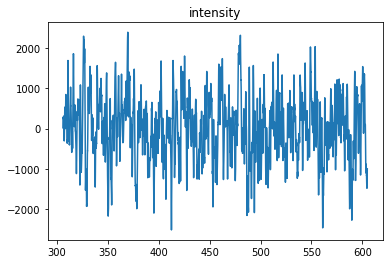

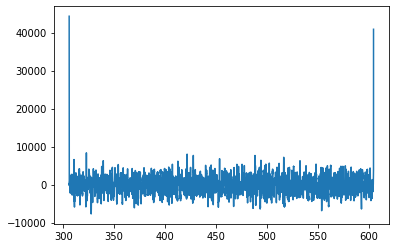

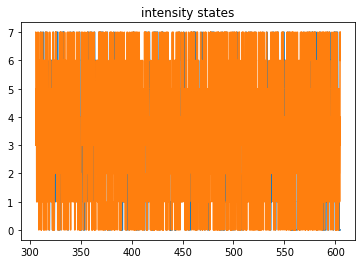

13297773 5981749 29909 29909


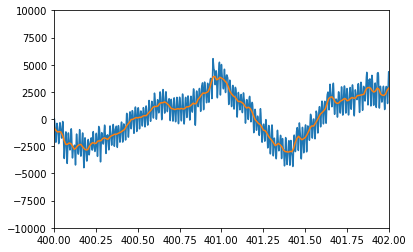

In [7]:
expdata=loadmat('20200408_OU_cutoff=2_sort_unit2.mat')
# stimulation data in the experiment
a_data=expdata['a_data']
TimeStamps=expdata['TimeStamps']
BinningInterval=0.01
SamplingRate=20000
# filtering raw data
T=np.arange(1,len(a_data[0])+1)/SamplingRate
a1=a_data[0][(T>=TimeStamps[0][0]) & (T<=TimeStamps[0][1])]
a1=a1-np.mean(a1)
b, a = signal.butter(2, 2*50/SamplingRate, btype='low', analog=False)
inten = signal.filtfilt(b, a, a1) 
v_inten = ndimage.gaussian_filter1d(inten, sigma=1, order=1, mode='wrap')*SamplingRate

# data downsample to sampling rate 100hz (dt=0.01s)
down_index=np.arange(TimeStamps[0][0]*SamplingRate,TimeStamps[0][1]*SamplingRate,200)
down_index=down_index.astype(int)
T1=T[down_index]
inten_index=np.arange(0,len(inten),200)
inten1=inten[inten_index] #x
v_inten1=ndimage.gaussian_filter1d(inten1, sigma=1, order=1, mode='wrap') / BinningInterval

plt.plot(T1,inten1)
plt.xlim()
plt.title('intensity')
plt.show()
plt.plot(T1,v_inten1)
plt.show()

intenstate=EqualState(inten1,8)
v_intenstate=EqualState(v_inten1,8)
plt.plot(T1,intenstate)
plt.plot(T1,v_intenstate)
plt.title('intensity states')
plt.xlim()
plt.show()

print(len(T),len(v_inten),len(T1),len(v_inten1))
plt.plot(T[(T>=TimeStamps[0][0]) & (T<=TimeStamps[0][1])],v_inten)
plt.plot(T1,v_inten1)
plt.xlim(400,402)
plt.ylim(-10000,10000)
plt.show()

In [8]:
# spikes
Spikes=expdata['Spikes']
spikes1=[]
for i in range(60):
    if len(Spikes[0][i])==0:
        spikes1.append(Spikes[0][i])
    else:
        temp=[]
        temp=Spikes[0][i][0]
        temp=temp[(temp>TimeStamps[0][0]) & (temp<TimeStamps[0][1])]
        spikes1.append(temp)

BinningTime=T1-BinningInterval/2
BinningTime=np.append(BinningTime,(BinningTime[-1]+BinningInterval)) # precise Binning time, binning result of spikes will shift 5ms
binspikes=[]
for j in range(np.size(spikes1,0)):
    hist, bin_edges = np.histogram(spikes1[j],bins=BinningTime,density=False)
    tempspikes=np.array(hist)
    binspikes.append(tempspikes)

(-1495.4, 31403.4)

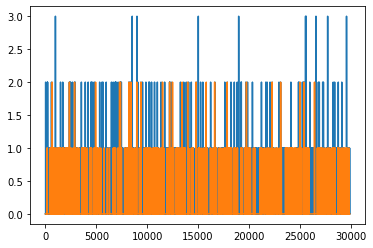

In [12]:
plt.plot(binspikes[40])
plt.plot(binspikes[20])
plt.xlim()

In [10]:
# #assign states
# edges = np.append(min(r), np.array([np.std(r),2*np.std(r),3*np.std(r)])+np.mean(r));
# rstate=np.zeros(len(r))
# for i in range(4):
#     rstate[r>=edges[i]] = i
# rstate = rstate.astype(int)
# xstate = EqualState(x, 6)
# vstate = EqualState(v, 6)
# ystate = EqualState(y, 6)

In [10]:
#calculate information
window = [-1,1] # second
MIx1=[]
MIv1=[]
MIjoint1=[]
Redun1=[]
Ux1=[]
Uv1=[]
Syner1=[]
for i in range(60):
    print('processing channel:',i+1)
    timeshift, MIx, MIv, MIjoint, Redun = PIfunc(binspikes[i], intenstate, v_intenstate, BinningInterval, window)
    Ux = MIx-Redun
    Uv = MIv-Redun
    Syner = MIjoint-MIx-MIv+Redun
    
    MIx1.append(MIx)
    MIv1.append(MIv)
    MIjoint1.append(MIjoint)
    Redun1.append(Redun)
    Ux1.append(Ux)
    Uv1.append(Uv)
    Syner1.append(Syner)

processing channel: 1


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log2
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log2
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log2
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log2
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in multiply
c:\program files\pyt

processing channel: 2
processing channel: 3
processing channel: 4
processing channel: 5
processing channel: 6
processing channel: 7
processing channel: 8
processing channel: 9
processing channel: 10
processing channel: 11
processing channel: 12
processing channel: 13
processing channel: 14
processing channel: 15
processing channel: 16
processing channel: 17
processing channel: 18
processing channel: 19
processing channel: 20
processing channel: 21
processing channel: 22
processing channel: 23
processing channel: 24
processing channel: 25
processing channel: 26
processing channel: 27
processing channel: 28
processing channel: 29
processing channel: 30
processing channel: 31
processing channel: 32
processing channel: 33
processing channel: 34
processing channel: 35
processing channel: 36
processing channel: 37
processing channel: 38
processing channel: 39
processing channel: 40
processing channel: 41
processing channel: 42
processing channel: 43
processing channel: 44
processing channel:

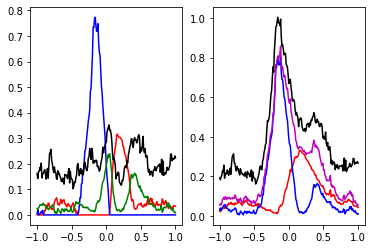

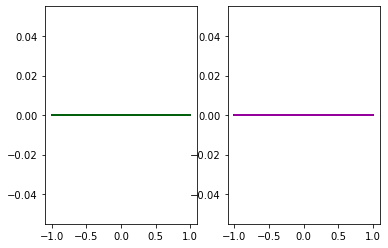

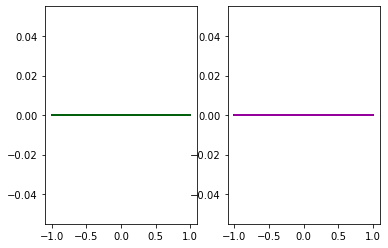

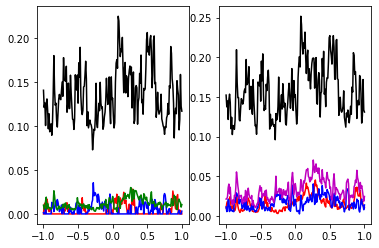

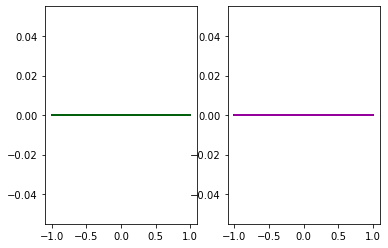

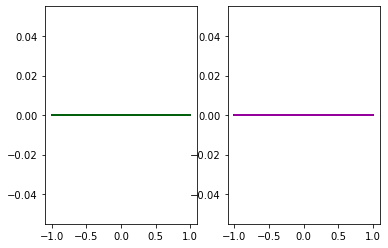

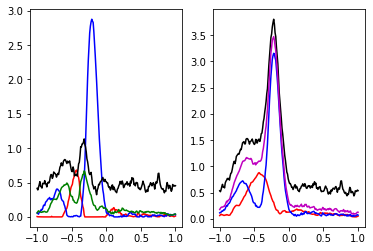

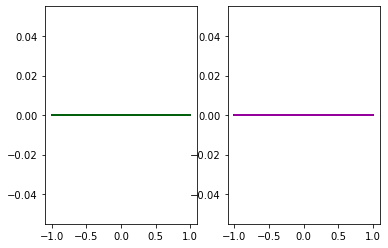

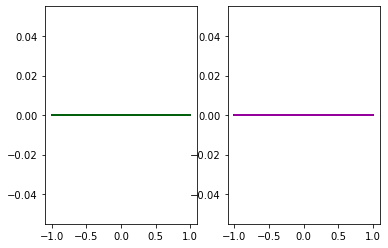

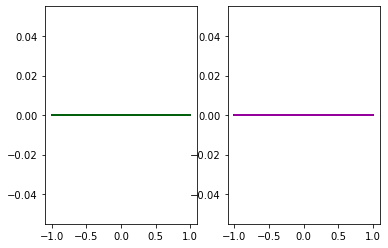

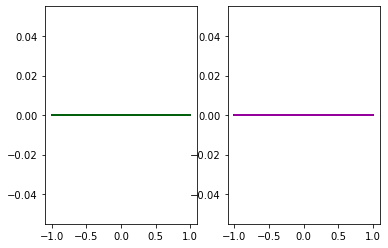

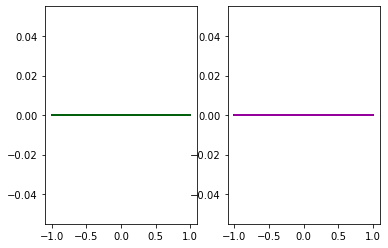

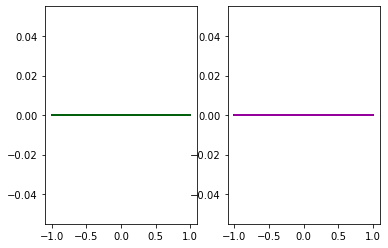

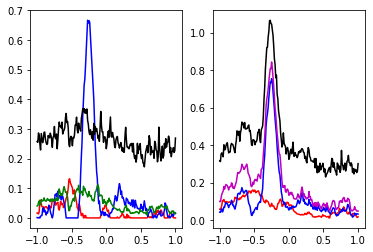

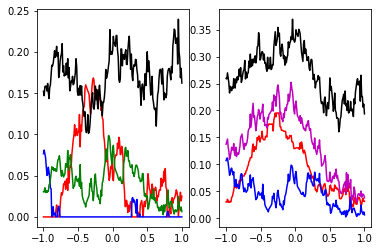

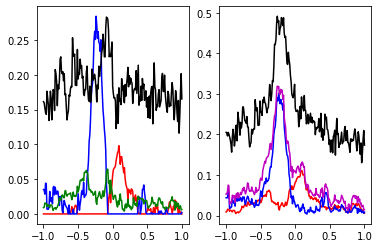

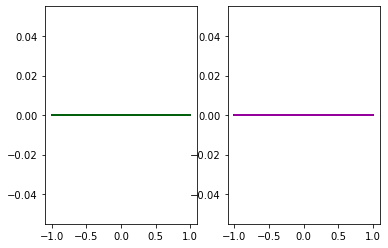

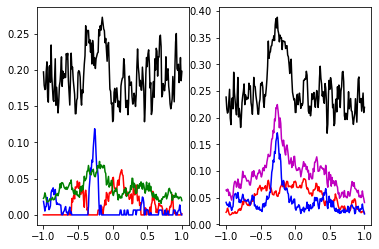

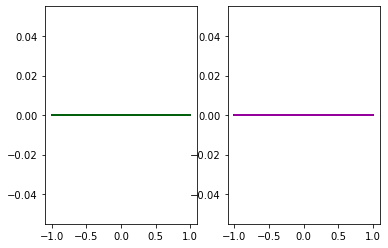

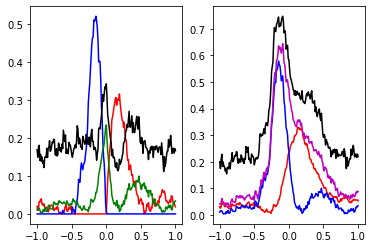

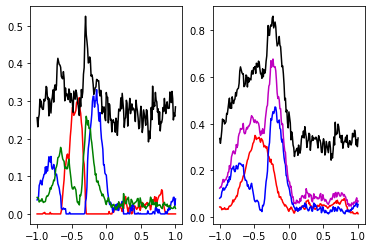

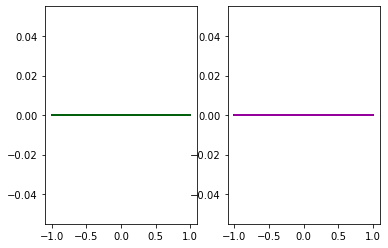

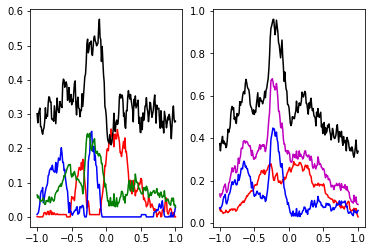

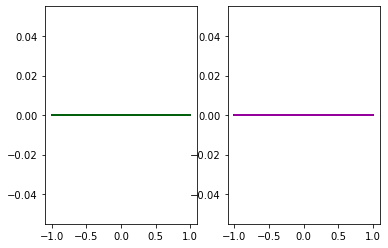

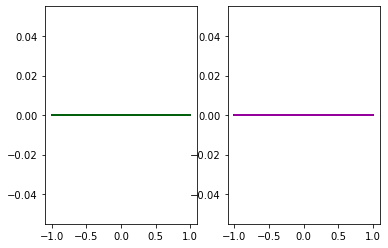

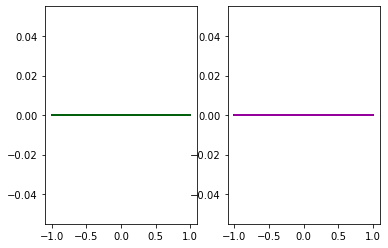

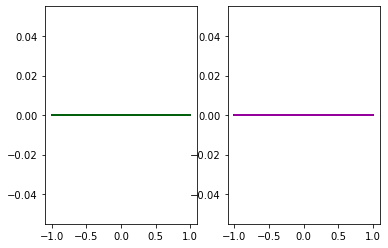

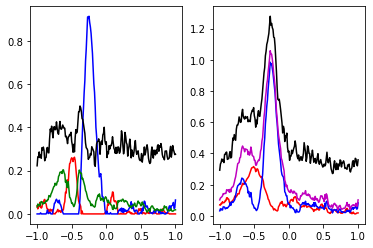

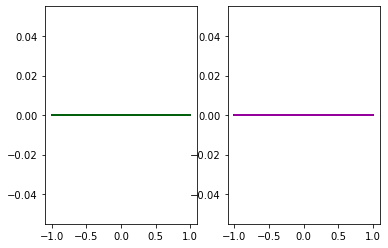

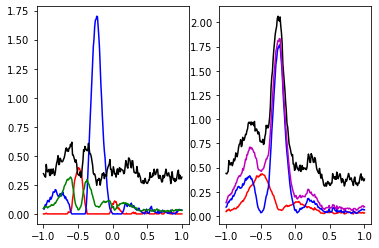

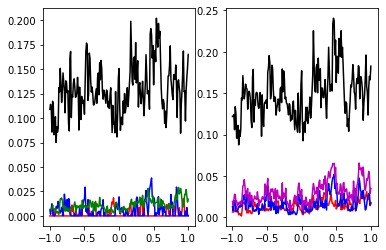

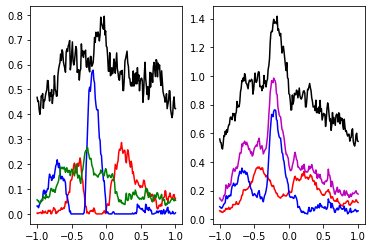

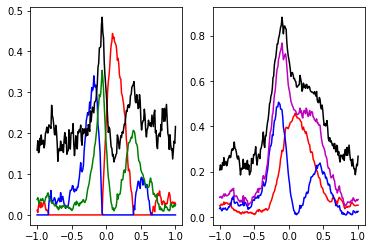

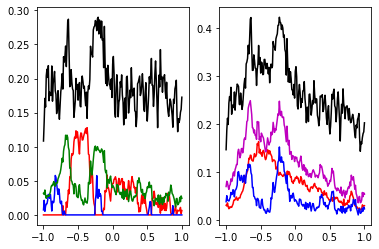

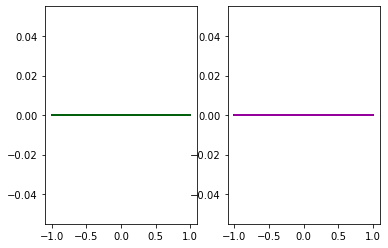

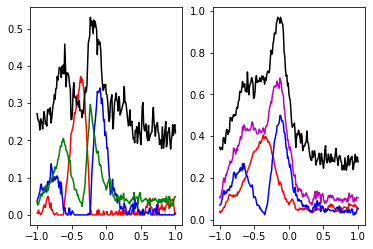

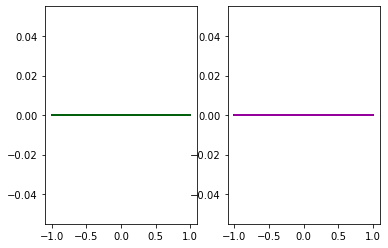

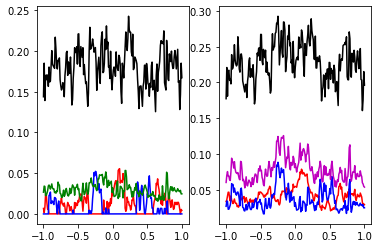

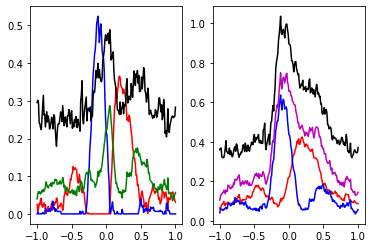

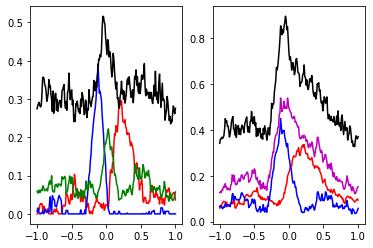

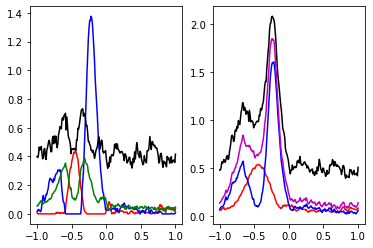

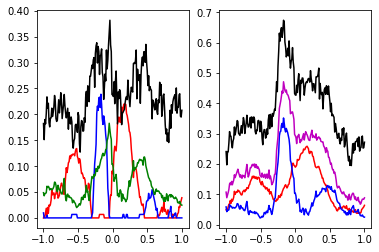

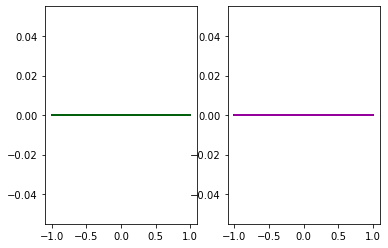

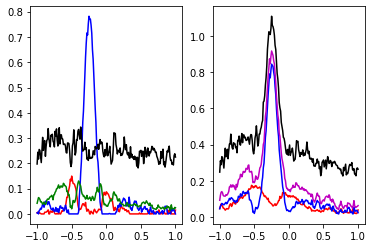

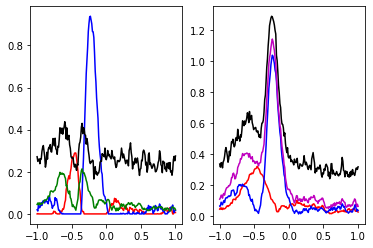

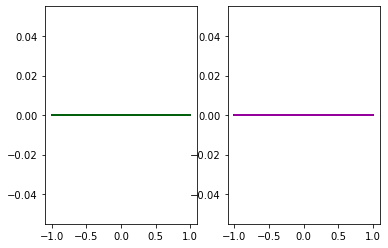

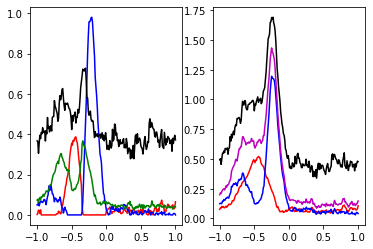

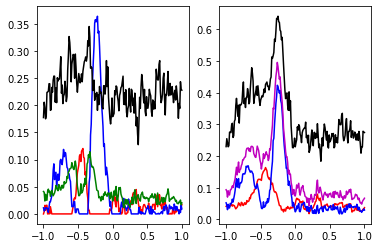

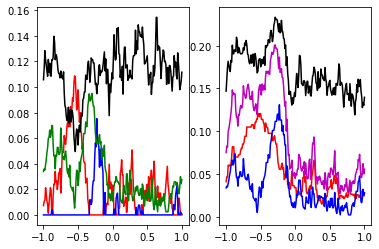

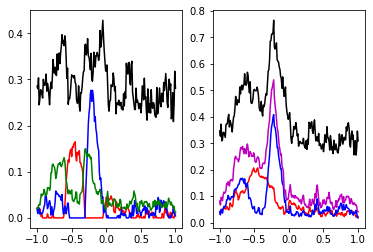

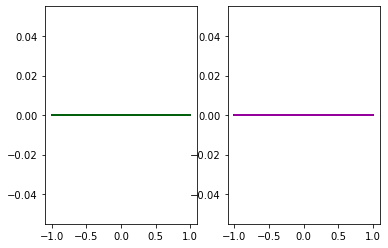

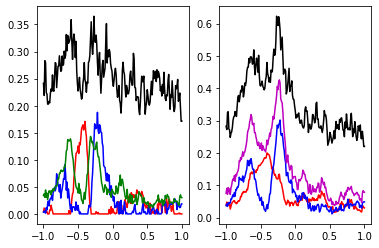

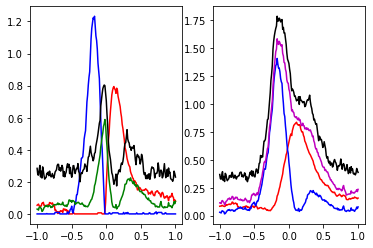

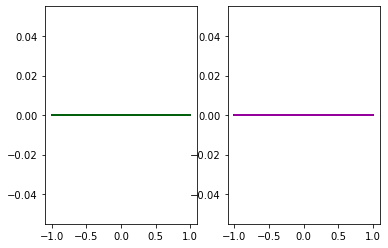

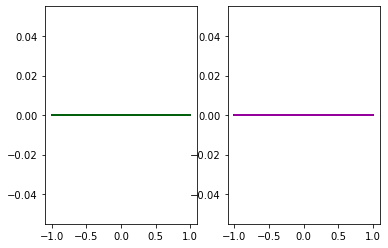

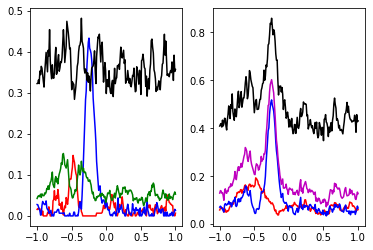

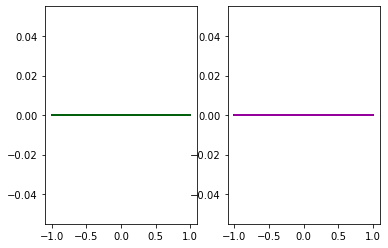

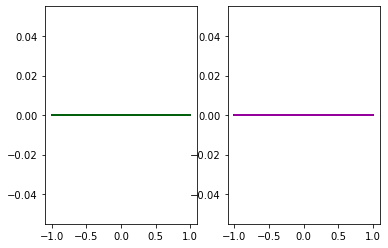

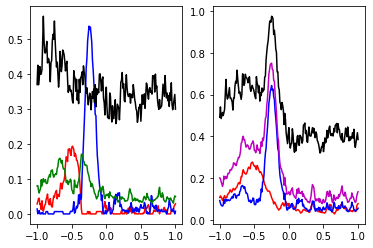

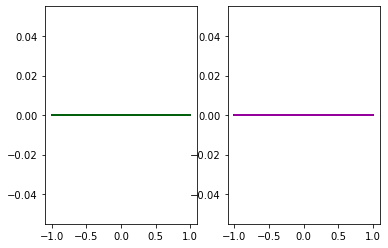

In [11]:
for i in range(60):
    #plot PIs (r,x,v)
    plt.subplot(1,2,1)
    plt.plot(timeshift,Ux1[i], 'r-')
    plt.plot(timeshift,Uv1[i], 'b-')
    plt.plot(timeshift,Syner1[i], 'k-')
    plt.plot(timeshift,Redun1[i], 'g-')
    #plot MIs
    plt.subplot(1,2,2)
    plt.plot(timeshift,MIx1[i], 'r-')
    plt.plot(timeshift,MIv1[i], 'b-')
    plt.plot(timeshift,MIjoint1[i], 'k-')
    plt.plot(timeshift,MIx1[i]+MIv1[i], 'm-')
    plt.show()